In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage

Using TensorFlow backend.


In [60]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
#path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"
#model = load_model(path + r'models\\' + 'full_run1_epoch_4.h5')

model = load_model(path + 'models/' + 'full_run1_epoch_4.h5')

sigma = 1.2
alpha = 0.7
Xi = 40
width = 30
space = 30
noise = 2
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 


original_file = path + 'original_images/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

print(noisy_file)
im = np.array(Image.open(original_file))
imnoisy = np.array(Image.open(noisy_file))

im = im/256
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)
impredict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
impredict = impredict.reshape(1024,64)
impredict = impredict.astype(float)


mse = ((im - impredict) ** 2).mean()
print(mse)

snr_predict = (im**2).mean() / mse
snr_predict_dB = 10 * math.log(snr_predict)

snr_noise = ((im**2).mean()) / (((im - imnoisy) ** 2).mean()) 
snr_noise_dB = 10 * math.log(snr_noise)

print(snr_predict_dB, snr_noise_dB, snr_predict_dB - snr_noise_dB)

del model

/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/noisy_images/nim_1.2e-09_0.7_4e-08_30_30_17_2.tiff
0.00254875539244
35.667091586207796 -0.9494519167190173 36.61654350292682


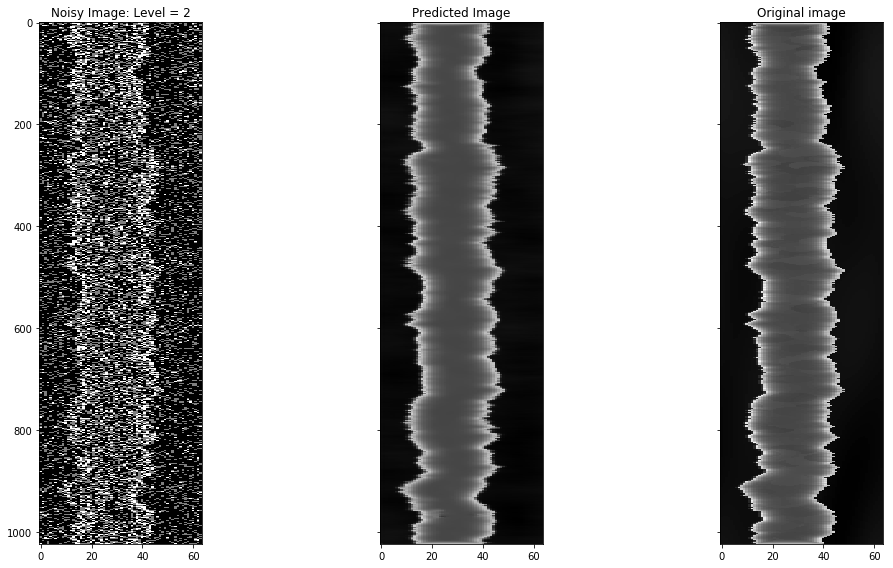

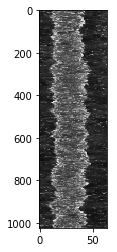

0.828125 0.10546875
0.804478704929 0.117639824748
0.99609375 0.0


In [61]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})


ax[0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0].set_title('Noisy Image: Level = {}'.format(noise))

ax[1].imshow(impredict, cmap = 'gray', aspect= 0.2)
ax[1].set_title('Predicted Image')

ax[2].imshow(im,cmap = 'gray',aspect = 0.2)
#ax[2].set_title('Original image with sigma = {}nm, Xi = {}nm, alpha = {}, width = {} pixels'.format(sigma, Xi, alpha, width))
ax[2].set_title('Original image')

fig.tight_layout()
plt.savefig('noisy_lines.png')
plt.show()

#import scipy.io as spio

mat2 = spio.loadmat(path + 'Image2.mat', squeeze_me=True)
DnCNN = np.array(mat2['image1'])

DnCNN = DnCNN/256

plt.imshow(DnCNN,aspect= 0.2)
plt.show()

print(np.max(im), np.min(im))
print(np.max(impredict), np.min(impredict))
print(np.max(imnoisy), np.min(imnoisy))

20.5423726099
PSNR noisy image = 10.034355634002008, PSNR predicted image = 25.936718423693492
MSE noisy image = 0.09921205299906433, MSE predicted image = 0.002548755392440794


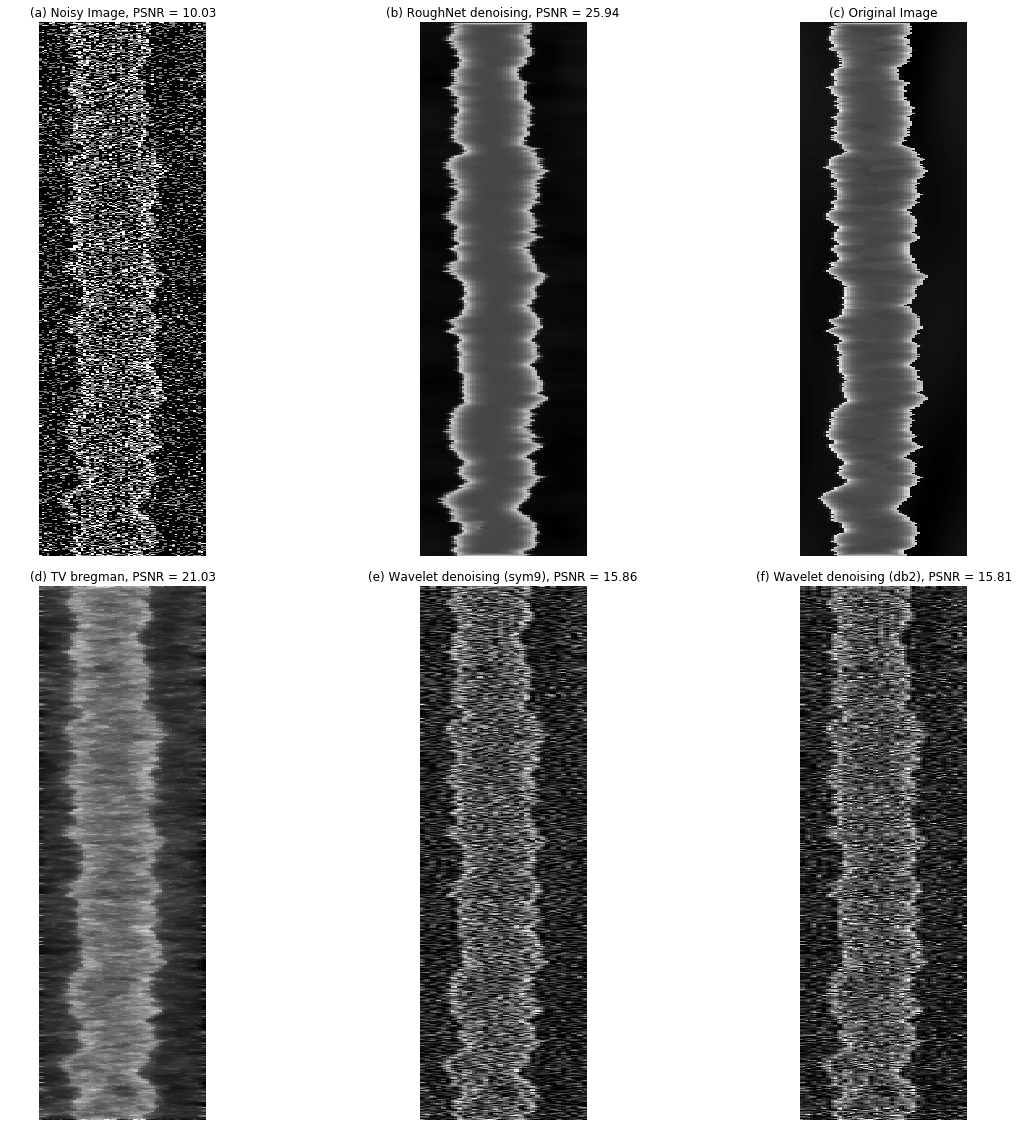

In [67]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, denoise_tv_bregman)
from skimage import measure
"""
impredict = (256*impredict).astype(int)
im = (256*im).astype(int)
imnoisy = (256*imnoisy).astype(int)

impredict = impredict.astype(float)
imnoisy = imnoisy.astype(float)
im = im.astype(float)

im = im/256
imnoisy = imnoisy/256
impredict = impredict/256
"""

psnr_DnCNN = measure.compare_psnr(im,DnCNN)
print(psnr_DnCNN)

psnr_noisy = measure.compare_psnr(im,imnoisy)
psnr_predict = measure.compare_psnr(im,impredict)
mse_noisy = measure.compare_mse(im, imnoisy)
mse_predict = measure.compare_mse(im, impredict)

print('PSNR noisy image = {}, PSNR predicted image = {}'.format(psnr_noisy,psnr_predict))
print('MSE noisy image = {}, MSE predicted image = {}'.format(mse_noisy,mse_predict))


# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma

im_denoise_tv_bregman = denoise_tv_bregman(imnoisy, weight = 1)
psnr_tv = measure.compare_psnr(im,im_denoise_tv_bregman)

im_denoise_wavelet_sym9 = denoise_wavelet(imnoisy, wavelet='sym9', multichannel=False)
psnr_wavelet_sym9 = measure.compare_psnr(im, im_denoise_wavelet_sym9)

im_denoise_wavelet_db2 = denoise_wavelet(imnoisy, wavelet='db2', multichannel=False)
psnr_wavelet_db2 = measure.compare_psnr(im, im_denoise_wavelet_db2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 16), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()


ax[0, 0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0, 0].axis('off')
ax[0, 0].set_title('(a) Noisy Image, PSNR = {0:.4g}'.format(psnr_noisy))

ax[0, 1].imshow(impredict,cmap = 'gray',aspect= 0.2)
ax[0, 1].axis('off')
ax[0, 1].set_title('(b) RoughNet denoising, PSNR = {0:.4g}'.format(psnr_predict))

ax[0, 2].imshow(im,cmap = 'gray',aspect= 0.2)
ax[0, 2].axis('off')
ax[0, 2].set_title('(c) Original Image')

ax[1, 0].imshow(im_denoise_tv_bregman, cmap = 'gray',aspect= 0.2)
ax[1, 0].axis('off')
ax[1, 0].set_title('(d) TV bregman, PSNR = {0:.4g}'.format(psnr_tv))

ax[1, 1].imshow(im_denoise_wavelet_sym9,cmap = 'gray',aspect= 0.2)
ax[1, 1].axis('off')
ax[1, 1].set_title('(e) Wavelet denoising (sym9), PSNR = {0:.4g}'.format(psnr_wavelet_sym9))

ax[1, 2].imshow(im_denoise_wavelet_db2,cmap = 'gray',aspect= 0.2)
ax[1, 2].axis('off')
ax[1, 2].set_title('(f) Wavelet denoising (db2), PSNR = {0:.4g}'.format(psnr_wavelet_db2))


fig.tight_layout()
plt.savefig('denoisers.png')
plt.show()

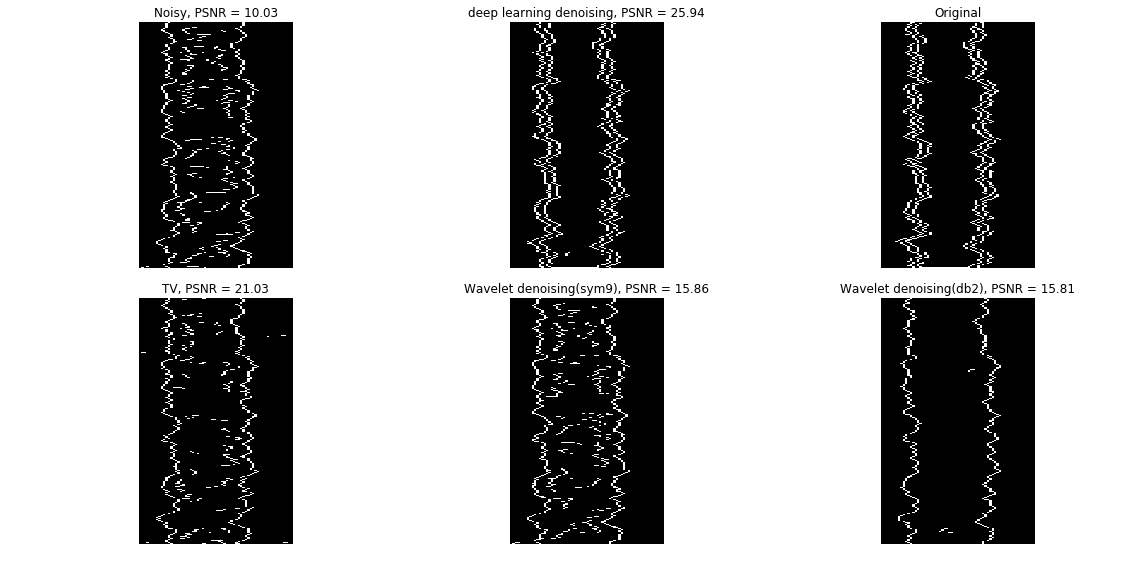

In [90]:
from scipy import ndimage as ndi
from skimage import feature


# Compute the Canny filter for two values of sigma
s = 1
edges_im = feature.canny(im, sigma = 1)
edges_imnoisy = feature.canny(imnoisy, sigma = 3)
edges_impredict = feature.canny(impredict, sigma = 1)
edges_im_tv = feature.canny(im_denoise_tv_bregman, sigma = 2)
edges_im_wavelet_sym9 = feature.canny(im_denoise_wavelet_sym9, sigma = 3)
edges_im_wavelet_db2 = feature.canny(im_denoise_wavelet_db2, sigma = 4)

# display results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex=True, sharey=True)

ax[0, 0].imshow(edges_imnoisy,cmap = 'gray',aspect= 0.1)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy, PSNR = {0:.4g}'.format(psnr_noisy))

ax[0, 1].imshow(edges_impredict,cmap = 'gray',aspect= 0.1)
ax[0, 1].axis('off')
ax[0, 1].set_title('deep learning denoising, PSNR = {0:.4g}'.format(psnr_predict))

ax[0, 2].imshow(edges_im,cmap = 'gray',aspect= 0.1)
ax[0, 2].axis('off')
ax[0, 2].set_title('Original')

ax[1, 0].imshow(edges_im_tv, cmap = 'gray',aspect= 0.1)
ax[1, 0].axis('off')
ax[1, 0].set_title('TV, PSNR = {0:.4g}'.format(psnr_tv))


ax[1, 1].imshow(edges_im_wavelet_sym9,cmap = 'gray',aspect= 0.1)
ax[1, 1].axis('off')
ax[1, 1].set_title('Wavelet denoising(sym9), PSNR = {0:.4g}'.format(psnr_wavelet_sym9))


ax[1, 2].imshow(edges_im_wavelet_db2,cmap = 'gray',aspect= 0.1)
ax[1, 2].axis('off')
ax[1, 2].set_title('Wavelet denoising(db2), PSNR = {0:.4g}'.format(psnr_wavelet_db2))


fig.tight_layout()

plt.show()

0.88220680186 0.859283997312 0.907250739721
0.463512405443 0.644992732517


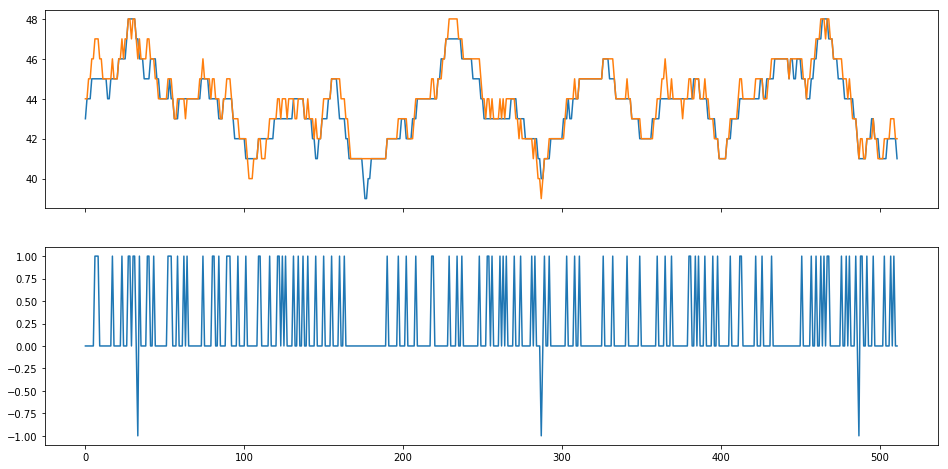

In [92]:
from skimage.filters import roberts, sobel, scharr

edge_sobel = sobel(im)

#linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'

linescan = []
with open(linescan_file,'r') as f:
    for line in f:
        a, b = line.split(',')
        linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8),sharex=True, sharey=False)

redge1 = np.argmax(np.fliplr(edges_im), axis = 1)[256:768]
redge2 = np.argmax(np.fliplr(edges_impredict), axis = 1)[256:768]
print(np.std(redge1)/2, np.std(redge2)/2, np.std(rightline[255:767].astype(int))/2)

redge1 = 62 - redge1
redge2 = 62 - redge2

rorig_rmse = np.sqrt(((rightline[255:767].astype(int) - redge1)**2).mean())                      
rpred_rmse = np.sqrt(((rightline[255:767].astype(int) - redge2)**2).mean())
print(rorig_rmse, rpred_rmse)



ax[0].plot(redge2)
ax[0].plot(rightline[255:767].astype(int))

ax[1].plot(rightline[255:767].astype(int) - redge1)
plt.show()



#print(np.sum((redge1 - redge2)**2))
#print(np.sum((rightline[255:767].astype(int) - redge1)**2))
#print(np.sum((rightline[255:767].astype(int) - redge2)**2))

1.05148348689 1.05753197155 1.06634141215
0.302979991089 0.597847702178


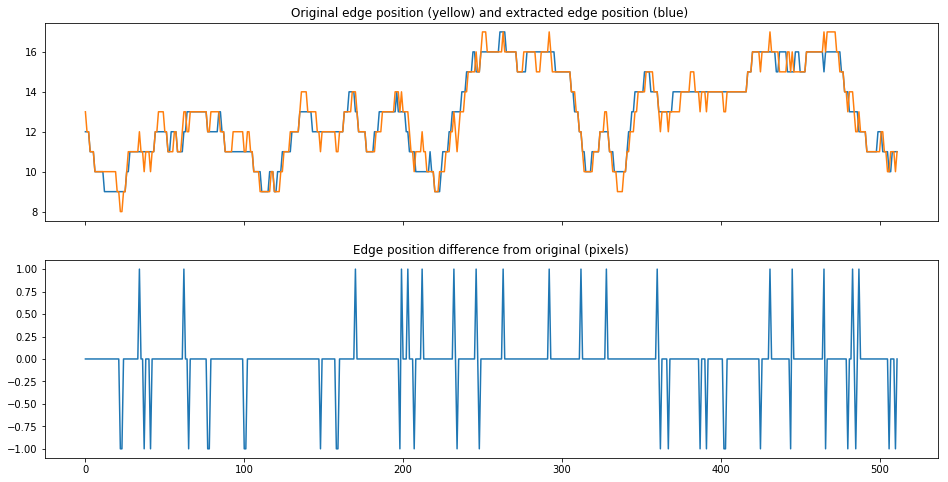

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8),sharex=True, sharey=False)

ledge1 = np.argmax(edges_im, axis = 1)[256:768]
ledge2 = np.argmax(edges_impredict, axis = 1)[256:768]
print(np.std(ledge1)/2, np.std(ledge2)/2, np.std(leftline[255:767].astype(int))/2)

lorig_rmse = np.sqrt(((leftline[255:767].astype(int) - ledge1)**2).mean())
lpred_rmse = np.sqrt(((leftline[255:767].astype(int) - ledge2)**2).mean())

print(lorig_rmse, lpred_rmse)

ax[0].plot(ledge2)
ax[0].plot(leftline[255:767].astype(int))
ax[0].set_title('Original edge position (yellow) and extracted edge position (blue) ')
ax[1].plot(leftline[255:767].astype(int) - ledge1)
ax[1].set_title('Edge position difference from original (pixels)')
plt.show()

#print(np.sum((ledge1 - ledge2)**2))
#print(np.sum((leftline[255:767].astype(int) - ledge1)**2))
#print(np.sum((leftline[255:767].astype(int) - ledge2)**2))